# PROJECT EDA

**Pocess to explore the data and identify patterns in the data**

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns


pd.set_option("display.max_columns", 100)


In [23]:
# Load the main dataset 
df = pd.read_csv('cleaned_dataset.csv')

# Display the first few rows of the dataset 
df.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished
0,951920,6000,1750,7750.0,2025-11-29,5 weeks credit ease,engineer,2026-03-01,1819,female,8000.0,3500,1,500,2025-11-29,2025-11-29,0,5.0,food & hospitality,green grocery (fruit/vegetables),2017
1,951902,4000,1250,5250.0,2025-11-28,5 weeks credit ease,molo,2026-02-01,1818,female,9600.0,2500,1,1550,2025-11-28,2025-11-28,0,4.0,food & hospitality,retail shop,2019
2,949962,4000,1250,5250.0,2025-11-26,5 weeks credit ease,engineer,2025-12-31,1815,female,8000.0,3500,1,1350,2025-11-26,2025-11-26,0,4.0,food & hospitality,green grocery (fruit/vegetables),2014
3,949189,4000,1250,5250.0,2025-11-25,5 weeks credit ease,molo,2025-12-30,1814,female,10000.0,1500,1,1000,2025-11-25,2025-11-25,0,4.0,food & hospitality,green grocery (fruit/vegetables),2018
4,948984,4000,1250,5250.0,2025-11-24,5 weeks credit ease,molo,2025-12-29,1813,female,10000.0,1500,1,1550,2025-11-24,2025-11-24,0,4.0,business & information,bureau & publishing services,2018


In [24]:
# James: Convert date columns to datetime format for easier analysis

# BorrowDate:  MM/DD/YYYY (Keep dayfirst=False)
df["BorrowDate"] = pd.to_datetime(df["BorrowDate"], errors="coerce", dayfirst=False)

# problematic columns: Use format='mixed' to handle the mix of DD/MM/YYYY and YYYY-MM-DD
df["loan_repayment_first_payment"] = pd.to_datetime(df["loan_repayment_first_payment"], errors="coerce", dayfirst=True, format='mixed')
df["loan_repayment_last_payment"] = pd.to_datetime(df["loan_repayment_last_payment"], errors="coerce", dayfirst=True, format='mixed')

# ClearDate:  YYYY-MM-DD
df["ClearDate"] = pd.to_datetime(df["ClearDate"], errors="coerce", format="%Y-%m-%d")

# Check the result
df.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished
0,951920,6000,1750,7750.0,2025-11-29,5 weeks credit ease,engineer,2026-03-01,1819,female,8000.0,3500,1,500,2025-11-29,2025-11-29,0,5.0,food & hospitality,green grocery (fruit/vegetables),2017
1,951902,4000,1250,5250.0,2025-11-28,5 weeks credit ease,molo,2026-02-01,1818,female,9600.0,2500,1,1550,2025-11-28,2025-11-28,0,4.0,food & hospitality,retail shop,2019
2,949962,4000,1250,5250.0,2025-11-26,5 weeks credit ease,engineer,2025-12-31,1815,female,8000.0,3500,1,1350,2025-11-26,2025-11-26,0,4.0,food & hospitality,green grocery (fruit/vegetables),2014
3,949189,4000,1250,5250.0,2025-11-25,5 weeks credit ease,molo,2025-12-30,1814,female,10000.0,1500,1,1000,2025-11-25,2025-11-25,0,4.0,food & hospitality,green grocery (fruit/vegetables),2018
4,948984,4000,1250,5250.0,2025-11-24,5 weeks credit ease,molo,2025-12-29,1813,female,10000.0,1500,1,1550,2025-11-24,2025-11-24,0,4.0,business & information,bureau & publishing services,2018


# Final data cleanup

In [25]:
# James: More data cleaning 
# A customer cannot make a repayment 100 days BEFORE they borrowed the money.
# We allow a small buffer (-10 days) for potential booking errors, but anything less is garbage.

df['days_to_first'] = (df['loan_repayment_first_payment'] - df['BorrowDate']).dt.days
df = df[(df['days_to_first'] >= -10) | (df['days_to_first'].isna())].copy()

In [26]:
# James: The data logs the same loan twice. We keep only the first instance.
df = df.drop_duplicates(subset=['CustomerId', 'BorrowDate'], keep='first')

In [27]:
# James: A loan cannot be cleared BEFORE it was borrowed.
df = df[df['ClearDate'] >= df['BorrowDate']].copy()

In [28]:
# James: A business established in 2024 cannot borrow money in 2023.
df = df[df['YearEstablished'] <= df['BorrowDate'].dt.year].copy()

In [29]:
# James: Cleanup to remove Product types (sme - 3 months, sme - 4 months and 12 weeks credit ease) from the dataset
df = df[~df['Product'].isin(['sme - 3 months', 'sme - 4 months', '12 weeks credit ease'])]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1565 entries, 0 to 3469
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LoanId                        1565 non-null   int64         
 1   AmountDisbursed               1565 non-null   int64         
 2   Interest                      1565 non-null   int64         
 3   LoanBalance                   1565 non-null   float64       
 4   BorrowDate                    1565 non-null   datetime64[ns]
 5   Product                       1565 non-null   object        
 6   Branch                        1565 non-null   object        
 7   ClearDate                     1565 non-null   datetime64[ns]
 8   CustomerId                    1565 non-null   int64         
 9   Gender                        1565 non-null   object        
 10  LoanLimit                     1565 non-null   float64       
 11  CreditScore                   1565 

# PUT YOUR CODE HERE

**Please mark your code with the first comment having your name. e.g. James - then explain what you are doing in the block**

An example is above when I did final cleanup


In [30]:
# James
# Understading the target variable Default where default is when ClearDate is greater than 2025-12-15 and LoanBalance is greater than 0
defaulters = ((df['ClearDate'] < '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)
print("Number of defaulters:", defaulters.sum())

# Calculate the percentage of defaults vs non-defaults
default_counts = defaulters.value_counts(normalize=True) * 100
print("Percentage of Defaults vs Non-Defaults:\n", default_counts)


Number of defaulters: 133
Percentage of Defaults vs Non-Defaults:
 0    91.501597
1     8.498403
Name: proportion, dtype: float64


--- Default Rates by Branch (%) ---
Branch
engineer    18.20
molo         5.03
dtype: float64


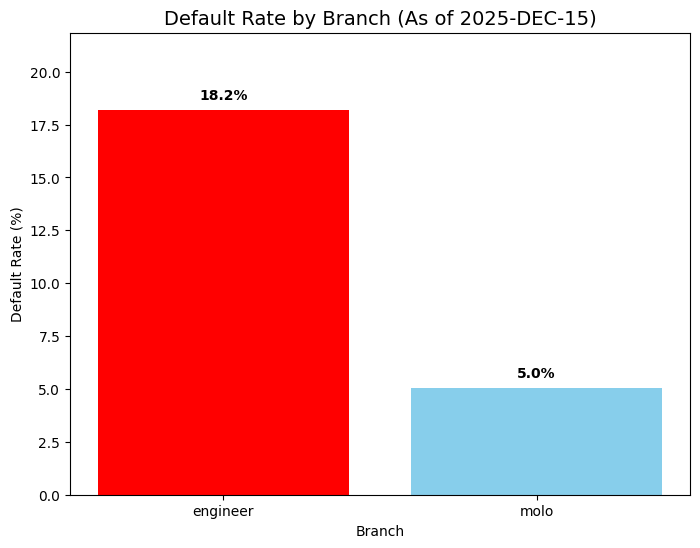

In [31]:
# James
# Visualizing the percentage of defaulters/number of loans based on branch as a chart

# Calculate Default Rate by Branch
branch_stats = defaulters.groupby(df['Branch']).mean() * 100

print("--- Default Rates by Branch (%) ---")
print(branch_stats.round(2))

# Visualization
plt.figure(figsize=(8, 6))
colors = ['red', 'skyblue']

plt.bar(branch_stats.index, branch_stats.values, color=colors)

plt.title('Default Rate by Branch (As of 2025-DEC-15)', fontsize=14)
plt.ylabel('Default Rate (%)')
plt.xlabel('Branch')
plt.ylim(0, max(branch_stats.values) * 1.2) 

for i, v in enumerate(branch_stats.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()